In [1]:
import sys
from pathlib import Path
import functools

import mujoco
from brax import envs
import jax
import jax.numpy as jp

resources_dir = Path.cwd().parent
shac_dir = Path(Path.cwd().parent,
                Path('SHAC'))
sys.path.append(str(resources_dir))
sys.path.append(str(shac_dir))
from envs import register_framed_hopper
import shac.networks as shac_networks
import shac.train as  shac

In [2]:
env_name = 'framed_hopper'

log_sigma = None
make_networks_factory = functools.partial(
    shac_networks.make_shac_networks,
        policy_hidden_layer_sizes=(64, 64),
        value_hidden_layer_sizes =(64, 64),
        scalar_var=False,
        layer_norm=True)

In [3]:
# Parameters
num_grad_checks = None

num_epochs = 200
num_evals = num_epochs + 1

unroll_length = 32

num_envs = 64

# critic_batch_size = 512/(32/unroll_length)/(64/num_envs)
# critic_batch_size = 1

num_timesteps = (num_envs*unroll_length)*num_epochs

num_critic_minibatches = 4
num_critic_data = num_envs*unroll_length
critic_batch_size = num_critic_data / num_critic_minibatches

episode_length = 240 


In [4]:
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)

In [5]:
train_fn = functools.partial(shac.train, 
                            num_timesteps=num_timesteps, log_sigma=log_sigma,
                            num_evals=num_evals, use_tbx=True, tbx_logdir=f'{env_name}_log',
                            tbx_experiment_name="obs_hist", reward_scaling=1, 
                            num_eval_envs = 64, num_envs=num_envs,
                            unroll_length=unroll_length, critic_batch_size=critic_batch_size,
                            critic_epochs = 16,target_critic_alpha = 0.2,
                            discounting = 0.99, lambda_ = 0.95,
                            normalize_observations=True,
                            episode_length=episode_length, 
                            network_factory = make_networks_factory, 
                            seed=10, entropy_cost = 1e-6,
                            resample_init=True,
                            scramble_initial_times=True,
                            num_grad_checks=num_grad_checks,
                            save_all_checkpoints=True)

make_inference_fn, policy_params, value_params, _= train_fn(
  environment=env,
  eval_env=eval_env)


Env steps per training step: 2048
Training steps per epoch: 1
Critic minibatches per critic epoch: 4
Initial eval time: 8.7258 s
Deleting old checkpoints!
Checkpointed for epoch 0
Checkpointed for epoch 1
Checkpointed for epoch 2
Checkpointed for epoch 3
Checkpointed for epoch 4
Checkpointed for epoch 5
Checkpointed for epoch 6
Checkpointed for epoch 7
Checkpointed for epoch 8
Checkpointed for epoch 9
Checkpointed for epoch 10
Checkpointed for epoch 11
Checkpointed for epoch 12
Checkpointed for epoch 13
Checkpointed for epoch 14
Checkpointed for epoch 15
Checkpointed for epoch 16
Checkpointed for epoch 17
Checkpointed for epoch 18
Checkpointed for epoch 19
Checkpointed for epoch 20
Checkpointed for epoch 21
Checkpointed for epoch 22
Checkpointed for epoch 23
Checkpointed for epoch 24
Checkpointed for epoch 25
Checkpointed for epoch 26
Checkpointed for epoch 27
Checkpointed for epoch 28
Checkpointed for epoch 29
Checkpointed for epoch 30
Checkpointed for epoch 31
Checkpointed for epoch 

#### Eval

In [6]:
utils_path = Path(Path.cwd().parent,
                  Path("benchmarks"),
                  Path("quadruped_stability_studies"))
sys.path.append(str(utils_path))
from utils import plot_jacobian_norms, visualize_rollout, plot_rews

In [7]:
renderer = mujoco.Renderer(env.model)

In [8]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(policy_params))

rng = jax.random.key(141)
init_key, rollout_key, rng = jax.random.split(rng, 3)
s0 = jit_reset(init_key)

jit_inference_fn = jax.jit(make_inference_fn(policy_params))

In [9]:
if False:
    def spoof_policy(_, rng):
        bb = jax.random.choice(rng, jp.array([-1, 1]), 
                            p=jp.array([0.9, 1]))
        return bb.reshape(1), {}
        # return 2*(jax.random.uniform(rng).reshape(1)-0.5), {}
    jit_inference_fn = jax.jit(spoof_policy)

<Figure size 640x480 with 0 Axes>

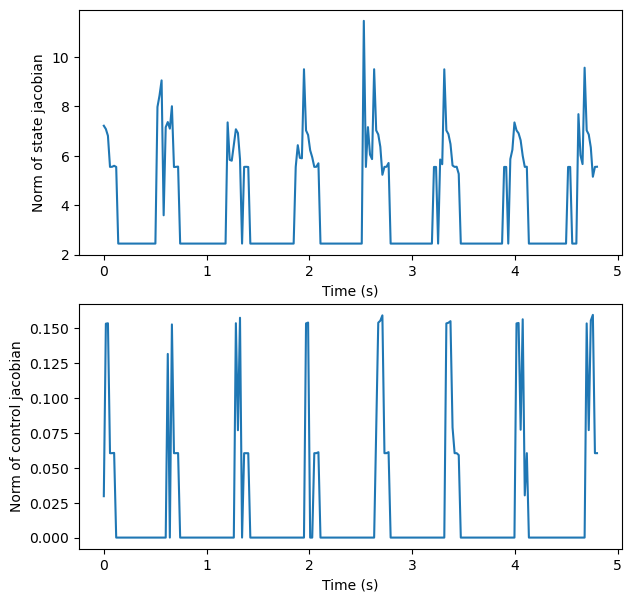

In [10]:
if True:
    """ 
    Nan gradients:
    - Not seen in forward-mode AD
    - Jacrev doesn't work
    - Unclear whether nan's in training come from user code or MJX
        - https://github.com/google-deepmind/mujoco/issues/1349
    """
    all_jacs, state_jacs, ctrl_jacs = plot_jacobian_norms(s0, rollout_key, env, jit_inference_fn,
                                                jit_step, episode_length=240,
                                                ret_jacs=True, jacmode='fwd')

In [11]:
state_h, states = visualize_rollout(s0, rollout_key, env, 
                                    jit_inference_fn, jit_step, renderer, 
                                    episode_length=240, print_nans=False, 
                                    print_dones=True, ret_states=True, camera="track")

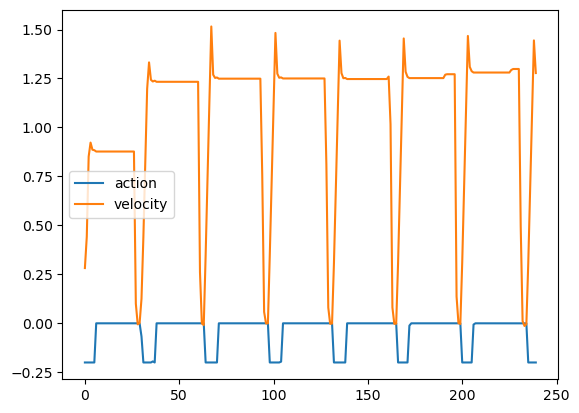

In [12]:
rews = plot_rews(states)